# Avalanche photodiode

This notebook demonstrates the modeling of an on-chip avalanche photodiode (APD). These photodetectors provide internal signal amplification by operating under high reverse bias and are used in many applications where it is necessary to detect very weak optical signals.

The internal gain in an APD arises from impact ionization, which occurs when the electric field is strong enough for charge carriers to gain sufficient kinetic energy to ionize atoms and create additional electron–hole pairs.

The device is inspired by the work of `Zhihong Huang, Cheng Li, Di Liang, Kunzhi Yu, Charles Santori, Marco Fiorentino, Wayne Sorin, Samuel Palermo, and Raymond G. Beausoleil, "25 Gbps low-voltage waveguide Si–Ge avalanche photodiode," Optica 3(8), (2016).` [DOI: https://doi.org/10.1364/OPTICA.3.000793](https://doi.org/10.1364/OPTICA.3.000793). It consists of a rib Si waveguide with n–p–i doping, the Ge region p- and pp-doped, and aluminum contacts.

The general workflow is as follows:

[1.](1) **Define multiphysics media**

 We will define both the optical and charge properties of the materials, including doping, and models for band-to-band tunneling and impact ionization.

[2.](2) **Run the optical simulation**

 We will use [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) to calculate the waveguide modes.

[3.](3) **Calculate optical absorption and carrier generation**

 With the field profile information, we will calculate the volumetric absorbed power:

 $P_{abs} = \tfrac{1}{2} \, \omega \, \varepsilon_0 \, \varepsilon'' \, |E|^2$,

 where $\varepsilon_0$ is the vacuum permittivity, and $\varepsilon''$ is the imaginary part of the complex permittivity.

 Next, we compute the electron–hole pair generation rate:

 $g = \tfrac{P_{abs}}{\hbar\omega q} \ \text{[1/(s µm}^3)]$

 where $q$ is the electron charge.

[4.](4) **Charge simulation**

 Finally, we will use the carrier generation data in a charge simulation to calculate the dark current and bright current.


<img src="img/APD.png" width="500" alt="Schematic">

In [25]:
import numpy as np
import tidy3d as td
from matplotlib import pyplot as plt
from tidy3d import web

# Prevent warning messages relevant only for FDTD simulations
td.config.logging_level = "ERROR"

## Simulation Setup

First we define global parameters used in the simulation.

Since the structure is symmetric to x = 0. we're modeling only the right half of the device. With this in mind, width is the width of half of the component, i.e., the half being modeled.

In [ ]:
# NOTE: all dimensions in um

z_size = 1

# si_bottom
si_b_w = 4.4  # width
si_b_h = 0.35 / 5  # height

# si_top
si_t_w = 2.2  # width
si_t_h = 0.35 * 4 / 5  # height

# Ge
ge_b_w = 1.8  # bottom width
ge_t_w = 1.15  # top width
ge_h = 0.35  # height

# SiO2 padding
sio2_w = si_b_w
sio2_h = 0.6

# emitter
emitter_w = 1  # width
emitter_h = 0.6  # height

# collector
collector_w = 0.5  # width
collector_h = 0.6  # height

total_h = 2 * sio2_h + si_b_h + si_t_h + ge_h

# Temperature (K)
T0 = 280

# structure overlap
s_ol = 1e-8

wvl_um = 1.55
freq0 = td.C_0 / wvl_um
P_in = 3e-4  # guided mode power [W]

### Defining Media

Now, we will define the media for the multiphysics simulations.

The Si and Ge will be modeled with the [SemiconductorMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SemiconductorMedium.html) class.

To accurately simulate the APD behavior, we will add to the semiconductor media a band-to-band tunneling model, defined with the [HurkxDirectBandToBandTunneling](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.HurkxDirectBandToBandTunneling.html) object, and an impact ionization model, defined with the [SelberherrImpactIonization](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.SelberherrImpactIonization.html) object.

In [ ]:
intrinsic_si = td.SemiconductorMedium(
    permittivity=11.7,
    N_c=td.IsotropicEffectiveDOS(m_eff=1.18),
    N_v=td.IsotropicEffectiveDOS(m_eff=0.8098),
    E_g=td.VarshniEnergyBandGap(eg_0=1.16, alpha=4.73e-4, beta=636),
    mobility_n=td.CaugheyThomasMobility(
        mu_min=52.2,
        mu=1471.0,
        ref_N=9.68e16,
        exp_N=0.68,
        exp_1=-0.57,
        exp_2=-2.33,
        exp_3=2.4,
        exp_4=-0.146,
    ),
    mobility_p=td.CaugheyThomasMobility(
        mu_min=44.9,
        mu=470.5,
        ref_N=2.23e17,
        exp_N=0.719,
        exp_1=-0.57,
        exp_2=-2.33,
        exp_3=2.4,
        exp_4=-0.146,
    ),
    R=[
        td.ShockleyReedHallRecombination(
            tau_n=td.FossumCarrierLifetime(
                tau_300=1e-12, alpha_T=0, A=1, B=0, C=1, N0=7.1e15, alpha=1
            ),
            tau_p=td.FossumCarrierLifetime(
                tau_300=1e-12, alpha_T=0, A=1, B=0, C=0, N0=7.1e15, alpha=1
            ),
        ),
        td.RadiativeRecombination(r_const=1.6e-14),
        td.AugerRecombination(c_n=2.8e-31, c_p=9.9e-32),
        td.HurkxDirectBandToBandTunneling(A=4e14, B=1.9e6, sigma=2.5),
        td.SelberherrImpactIonization(
            alpha_n_inf=7.03e5,
            alpha_p_inf=1.582e6,
            E_n_crit=1.23e6,
            E_p_crit=2.03e6,
            beta_n=1,
            beta_p=1,
        ),
    ],
    delta_E_g=td.SlotboomBandGapNarrowing(
        v1=9 * 1e-3,
        n2=1e17,
        c2=0.5,
        min_N=1e15,
    ),
)

intrinsic_ge = td.SemiconductorMedium(
    permittivity=16,
    N_c=td.IsotropicEffectiveDOS(m_eff=0.56),
    N_v=td.IsotropicEffectiveDOS(m_eff=0.29),
    E_g=td.VarshniEnergyBandGap(eg_0=0.7437, alpha=0.0004774, beta=235),
    mobility_n=td.CaugheyThomasMobility(
        mu_min=850,
        mu=3900,
        ref_N=2.6e17,
        exp_N=0.56,
        exp_1=0,
        exp_2=-1.66,
        exp_3=0,
        exp_4=0,
    ),
    mobility_p=td.CaugheyThomasMobility(
        mu_min=300,
        mu=1800,
        ref_N=1e17,
        exp_N=1,
        exp_1=0,
        exp_2=-2.33,
        exp_3=0,
        exp_4=0,
    ),
    R=[
        td.ShockleyReedHallRecombination(
            tau_n=td.FossumCarrierLifetime(
                tau_300=1e-10, alpha_T=0, A=1, B=0, C=0, N0=1e16, alpha=1
            ),
            tau_p=td.FossumCarrierLifetime(
                tau_300=1e-10, alpha_T=0, A=1, B=0, C=0, N0=1e16, alpha=1
            ),
        ),
        td.RadiativeRecombination(r_const=6.41e-14),
        td.AugerRecombination(c_n=1e-30, c_p=1e-30),
        td.HurkxDirectBandToBandTunneling(A=9.1e16, B=4.9e6, E_0=1, sigma=2.5),
        td.SelberherrImpactIonization(
            alpha_n_inf=4.9e5,
            alpha_p_inf=2.15e5,
            E_n_crit=7.9e5,
            E_p_crit=7.1e5,
            beta_n=1,
            beta_p=1,
        ),
    ],
    delta_E_g=None,
)

### Doping

Next, we will define the doping regions for both Si and Ge. We will use a [GaussianDoping](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GaussianDoping.html) object, which creates a Gaussian doping distribution that better reflects real doping profiles.

In [ ]:
n_Si = td.GaussianDoping.from_bounds(
    concentration=1e19,
    rmin=(-si_b_w, 0 - s_ol, -z_size),
    rmax=(si_b_w, 0.22, z_size),
    ref_con=1e16,
    width=0.05,
    source="ymin",
)
bg_Si = td.ConstantDoping.from_bounds(
    concentration=1e16, rmin=(-si_b_w, 0, -z_size), rmax=(si_b_w, si_b_h + si_t_h + s_ol, z_size)
)
p_Si = td.ConstantDoping.from_bounds(
    concentration=2e17,
    rmin=(-si_b_w, si_b_h + si_t_h - 0.05, -z_size),
    rmax=(si_b_w, si_b_h + si_t_h + s_ol, z_size),
)

p_Ge = td.GaussianDoping.from_bounds(
    rmin=(-ge_b_w, si_b_h + si_t_h, -z_size),
    rmax=(ge_b_w, si_b_h + si_t_h + ge_h, z_size),
    ref_con=1e17,
    concentration=1e18,
    width=0.35,
    source="ymax",
)

pp_Ge = td.GaussianDoping.from_bounds(
    rmin=(-ge_b_w, si_b_h + si_t_h + ge_h - 0.02 - 0.02, -z_size),
    rmax=(1.8, si_b_h + si_t_h + ge_h, z_size),
    ref_con=1e16,
    concentration=2e19,
    width=0.02,
    source="ymax",
)


doped_Si = intrinsic_si.updated_copy(N_a=[bg_Si, p_Si], N_d=[n_Si])
doped_Ge = intrinsic_ge.updated_copy(N_a=[p_Ge, pp_Ge])

### Defining the Multiphysics Medium

Finally, we can combine the optical and charge material properties into a [MultiPhysicsMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.MultiPhysicsMedium.html).

In [ ]:
doped_Si = intrinsic_si.updated_copy(N_a=[bg_Si, p_Si], N_d=[n_Si])
doped_Ge = intrinsic_ge.updated_copy(N_a=[p_Ge, pp_Ge])

Si = td.MultiPhysicsMedium(
    charge=doped_Si,
    optical=td.material_library["cSi"]["Palik_Lossless"],
    name="Si",
)

Ge = td.MultiPhysicsMedium(
    charge=doped_Ge,
    optical=td.material_library["Ge"]["Nunley"],
    name="Ge",
)

SiO2 = td.MultiPhysicsMedium(
    charge=td.ChargeInsulatorMedium(permittivity=3.9),
    optical=td.material_library["SiO2"]["Horiba"],
    name="SiO2",
)

Al = td.MultiPhysicsMedium(
    charge=td.ChargeConductorMedium(conductivity=1),
    optical=td.material_library["Al"]["RakicLorentzDrude1998"],
    name="Al",
)

### Structures

Now, we can define our geometries, assign material properties, and define the [Structure](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html) objects.

In [30]:
si_bottom = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-si_b_w, 0, -z_size), rmax=(si_b_w, si_b_h, z_size)),
    medium=Si,
    name="si_bottom",
)

si_top = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-si_t_w, si_b_h - s_ol, -z_size), rmax=(si_t_w, si_b_h + si_t_h + s_ol, z_size)
    ),
    medium=Si,
    name="si_top",
)

vertices = np.array(
    [
        (-ge_b_w, si_b_h + si_t_h),
        (ge_b_w, si_b_h + si_t_h),
        (ge_t_w, si_b_h + si_t_h + ge_h),
        (-ge_t_w, si_b_h + si_t_h + ge_h),
    ]
)
ge_struct = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-z_size, z_size)),
    medium=Ge,
    name="ge_struct",
)

sio2_struct = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-sio2_w, -sio2_h, -z_size), rmax=(sio2_w, si_b_h + si_t_h + ge_h + sio2_h, z_size)
    ),
    medium=SiO2,
    name="sio2_struct",
)

emitter = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(si_b_w - emitter_w, si_b_h - s_ol, -z_size), rmax=(si_b_w, si_b_h + emitter_h, z_size)
    ),
    medium=Al,
    name="emitter",
)

collector = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-collector_w, si_b_h + si_t_h + ge_h - s_ol, -z_size),
        rmax=(collector_w, si_b_h + si_t_h + ge_h + collector_h, z_size),
    ),
    medium=Al,
    name="collector",
)

structures = [sio2_struct, si_bottom, si_top, ge_struct, emitter, collector]

For easier communication between the optical and charge solvers, we can create a [Scene](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Scene.html) object containing all the structures and the background medium.

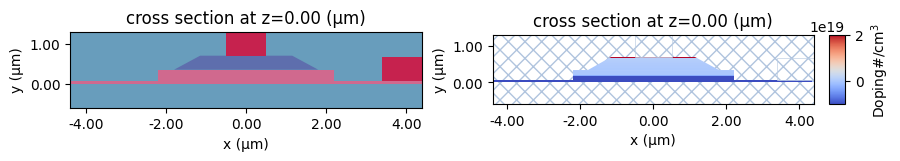

In [31]:
scene = td.Scene(
    structures=structures,
    medium=td.MultiPhysicsMedium(heat=td.FluidMedium()),
)

_, ax = plt.subplots(1, 2, figsize=(10, 10))
scene.plot(z=0, ax=ax[0])
scene.plot_structures_property(z=0, property="doping", ax=ax[1])
plt.show()

## Optical Simulation

### Optical Structures

Since the mode solver doesn't yet support [MultiPhysicsMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.MultiPhysicsMedium.html), we'll recreate these structures using only their optical properties.

In [32]:
opt_structs = [struct.updated_copy(medium=struct.medium.optical) for struct in structures]

### Defining the `ModeSolver` Object

Now, we will create a [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) object to run mode analysis and obtain field data. We will also add a [PermittivityMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PermittivityMonitor.html) to calculate the optical absorption and generation rate.

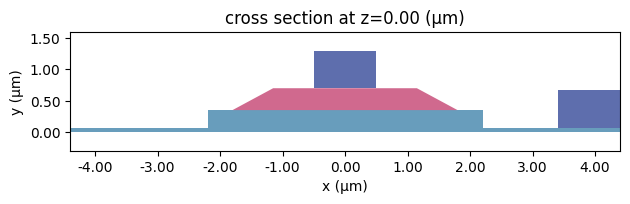

In [33]:
# Permittivity monitor
perm_mnt = td.PermittivityMonitor(
    size=(2 * si_b_w, total_h, 0),
    freqs=[freq0],
    name="permittivity",
)

# Cross-section simulation (x-size=0), periodic bc OK for mode extraction
opt_grid = td.GridSpec.auto(min_steps_per_wvl=30, wavelength=wvl_um)
opt_sim = td.Simulation(
    size=(2 * si_b_w, total_h, 0),
    center=(0, total_h / 2 - sio2_h / 2, 0),
    structures=opt_structs,
    medium=SiO2.optical,
    run_time=1e-15,
    grid_spec=opt_grid,
    boundary_spec=td.BoundarySpec.all_sides(td.Periodic()),
)

# Mode plane through the core
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode

mode_plane = td.Box.from_bounds(
    rmin=(-si_b_w, -sio2_h, 0), rmax=(si_b_w, si_b_h + si_t_h + ge_h + 1, 0)
)
ms = td.ModeSimulation.from_simulation(
    simulation=opt_sim,
    plane=mode_plane,
    mode_spec=td.ModeSpec(num_modes=1),
    freqs=[freq0],
    colocate=False,
    fields=["Ex", "Ey", "Ez"],
    monitors=[perm_mnt],
)
ms.plot()
plt.show()

Running the mode solver.

In [34]:
mode_data = web.run(ms, task_name="APD_opt")

18:09:20 -03 Created task 'APD_opt' with resource_id                            
             'mos-5e6d2c3c-c26e-47b8-b94f-6cc3b99665db' and task_type 'MODE'.

Output()

18:09:29 -03 Estimated FlexCredit cost: 0.007. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:09:31 -03 status = success

Output()

18:09:38 -03 Loading simulation from simulation_data.hdf5

### Mode Solver Results

First, we can visualize the field profiles.

n_eff: 4.338929562235545


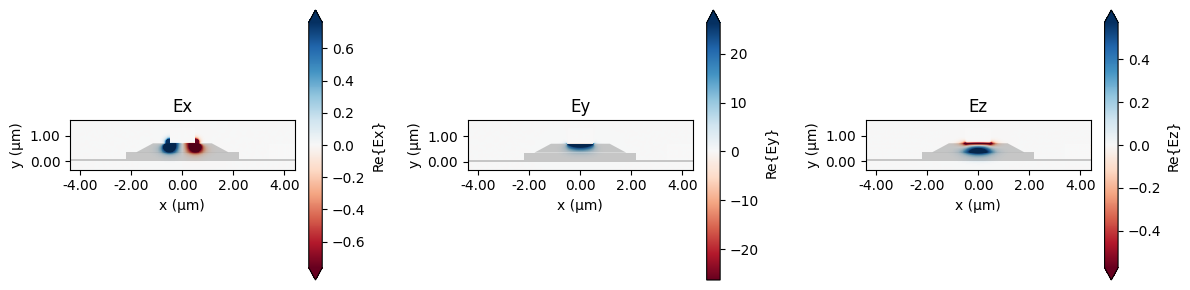

In [35]:
# Visualize mode fields (Ex, Ey, Ez) and report n_eff
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
mode_data.plot_field(field_name="Ex", ax=ax[0])
ax[0].set_title("Ex")
mode_data.plot_field(field_name="Ey", ax=ax[1])
ax[1].set_title("Ey")
mode_data.plot_field(field_name="Ez", ax=ax[2])
ax[2].set_title("Ez")
plt.tight_layout()
print("n_eff:", float(mode_data.modes.n_eff.isel(f=0, mode_index=0)))

plt.show()

## Generation Rate Calculation

### Optical Absorption Calculation

Now, we will calculate the optical absorption, defined as:

$$P_{abs} = \tfrac{1}{2} \, \omega \, \varepsilon_0 \, \varepsilon'' \, |E|^2$$

We will normalize the power to a scale factor $P_{in}$ of 30 mW, which is a common value for Si photonics.

In [36]:
# Extract mode fields and scale to target optical power P_in
Ex = mode_data.modes.Ex.isel(f=0, mode_index=0)
Ey = mode_data.modes.Ey.isel(f=0, mode_index=0)
Ez = mode_data.modes.Ez.isel(f=0, mode_index=0)

scale = np.sqrt(P_in)
Ex_s = Ex * scale
Ey_s = Ey * scale
Ez_s = Ez * scale

# Use xy plane boundaries (fields are not colocated)
x = Ex.coords["x"][1:-1]
y = Ex.coords["y"][1:-1]

# Extract permittivity values
eps_xx = mode_data["permittivity"].eps_xx.isel(f=0)
eps_yy = mode_data["permittivity"].eps_yy.isel(f=0)
eps_zz = mode_data["permittivity"].eps_zz.isel(f=0)

# Calculate the squared magnitude for each E-field component.
E_squared_magnitude_x = Ex_s * Ex_s.conj()
E_squared_magnitude_y = Ey_s * Ey_s.conj()
E_squared_magnitude_z = Ez_s * Ez_s.conj()

kwargs = {"fill_value": 0}
Power_density_E_x = np.pi * freq0 * td.EPSILON_0 * eps_xx.imag * E_squared_magnitude_x
Power_density_E_y = np.pi * freq0 * td.EPSILON_0 * eps_yy.imag * E_squared_magnitude_y
Power_density_E_z = np.pi * freq0 * td.EPSILON_0 * eps_zz.imag * E_squared_magnitude_z
Power_density_E = (
    Power_density_E_x.interp(x=x, y=y, kwargs=kwargs)
    + Power_density_E_y.interp(x=x, y=y, kwargs=kwargs)
    + Power_density_E_z.interp(x=x, y=y, kwargs=kwargs)
).real


print("Integrated power density:", float(Power_density_E.integrate(coord=["x", "y"])))

Integrated power density: 0.0001791077796829375


Next, we can calculate the pair generation rate by dividing the power density by the photon energy and the electron charge, assuming a quantum efficiency of 1.

 $$g = \tfrac{P_{abs}}{\hbar\omega q} \ \text{[1/(s µm}^3)]$$

/home/filipe/anaconda3/envs/develop/lib/python3.11/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


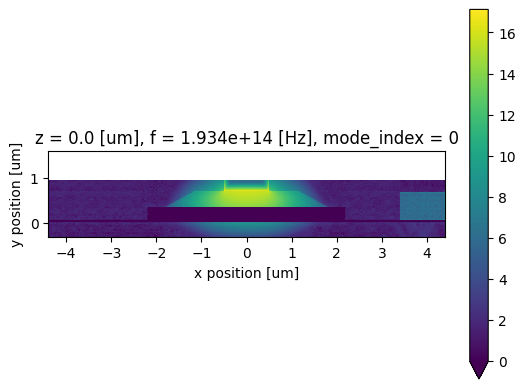

In [37]:
# Photon energy in eV
Eph = 2 * np.pi * td.HBAR * td.C_0 / wvl_um

# Assuming single optical frequency and a quantum efficiency of 1
g = Power_density_E / (Eph * td.Q_e)

# Visualize the generation rate
ax = np.log10(g.clip(0).T).plot(vmin=0).axes
ax.set_aspect("equal")
plt.show()

## Charge Simulation

Now, we can create a [HeatChargeSimulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.HeatChargeSimulation.html) object to perform a charge simulation and calculate the generated currents.

First, we will run a simulation without applying the previously calculated generation rate in order to obtain the **dark current**, which is the current that flows under a given reverse bias *in the absence of illumination*, originating from thermally generated carriers and tunneling processes.

Next, we will simulate the device including the generation rate produced by incident light. This yields the **bright current**, which is the useful photocurrent to be measured. The larger the difference between bright current and dark current (or more precisely, the larger the photocurrent relative to the noise associated with the dark current), the higher the APD sensitivity.


First, we define the voltage boundary conditions for the applied bias.

In [38]:
voltages = np.linspace(-11, 0, 12).tolist()

emitter_bc = td.HeatChargeBoundarySpec(
    placement=td.StructureStructureInterface(structures=[emitter.name, si_bottom.name]),
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=0)),
)
collector_bc = td.HeatChargeBoundarySpec(
    placement=td.StructureStructureInterface(structures=[ge_struct.name, collector.name]),
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=voltages)),
)
bcs = [emitter_bc, collector_bc]

Next, we define the carrier, potential, and steady-state current density monitors.

In [39]:
carrier_mnt = td.SteadyFreeCarrierMonitor(
    size=(td.inf, td.inf, td.inf), unstructured=True, name="carrier_mnt"
)
potential_mnt = td.SteadyPotentialMonitor(
    size=(td.inf, td.inf, td.inf), unstructured=True, name="potential_mnt"
)
j_mnt = td.SteadyCurrentDensityMonitor(
    size=(td.inf, td.inf, td.inf), unstructured=True, name="j_mnt"
)
monitors = [carrier_mnt, potential_mnt, j_mnt]

### Mesh

We define a [DistanceUnstructuredGrid](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DistanceUnstructuredGrid.html) mesh, using [GridRefinementLine](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GridRefinementLine.html) objects to refine the grid at the collector–Ge, Si–Ge, and Si n–Si p interfaces.

In [ ]:
collector_ref = td.GridRefinementLine(
    r1=(0, si_b_h + si_t_h + ge_h - 0.02, 0),
    r2=(ge_t_w, si_b_h + si_t_h + ge_h - 0.02, 0),
    dl_near=0.02 / 5,
    distance_near=0.02,
    distance_bulk=2 * 0.02,
)

ge_si_ref = td.GridRefinementLine(
    r1=(0, si_b_h + si_t_h, 0),
    r2=(ge_b_w, si_b_h + si_t_h, 0),
    dl_near=0.02 / 5,
    distance_near=0.02,
    distance_bulk=2 * 0.02,
)
si_b_h + 0.07

npp_doping_ref = td.GridRefinementLine(
    r1=(0, 0.22, 0),
    r2=(si_t_w, 0.22, 0),
    dl_near=0.02 / 5,
    distance_near=0.02,
    distance_bulk=2 * 0.02,
)

mesh_spec = td.DistanceUnstructuredGrid(
    dl_interface=si_b_h / 8,
    dl_bulk=si_b_h,
    distance_interface=si_b_h / 2,
    distance_bulk=si_b_h,
    relative_min_dl=0,
    sampling=500,
    uniform_grid_mediums=[Si.name, Ge.name],
    mesh_refinements=[collector_ref, ge_si_ref, npp_doping_ref],
)

### Tolerances and Analysis Type

Next, we define the tolerance settings and set the analysis type to [IsothermalSteadyChargeDCAnalysis](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.IsothermalSteadyChargeDCAnalysis.html).

In [41]:
convergence_settings = td.ChargeToleranceSpec(
    rel_tol=1e2, abs_tol=1e12, max_iters=100, ramp_up_iters=2
)

analysis_type = td.IsothermalSteadyChargeDCAnalysis(
    temperature=T0, convergence_dv=12, tolerance_settings=convergence_settings, fermi_dirac=True
)

Finally, we can create the [HeatChargeSimulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.HeatChargeSimulation.html) object for the `Scene` object.

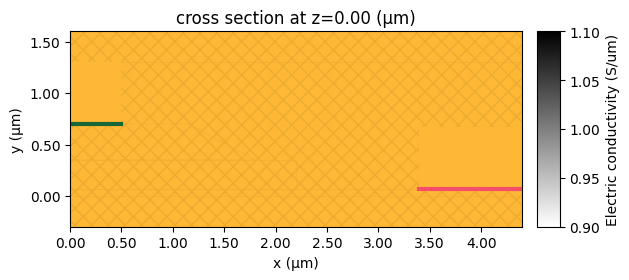

In [42]:
sim = td.HeatChargeSimulation.from_scene(
    scene=scene,
    size=(si_b_w, total_h, 0),
    center=(si_b_w / 2, total_h / 2 - sio2_h / 2, 0),
    monitors=monitors,
    grid_spec=mesh_spec,
    boundary_spec=bcs,
    analysis_spec=analysis_type,
)

sim.plot_property(z=0, property="electric_conductivity")
plt.show()

### Run Charge Dark Simulation

Now, we can run the simulation to calculate the dark current generated without incident light.

In [43]:
results = web.run(sim, task_name="APD_charge")

18:09:41 -03 Created task 'APD_charge' with resource_id                         
             'hec-a75ca123-a125-4a20-967f-f53c0f333268' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

18:09:51 -03 Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:09:54 -03 status = success

Output()

18:10:19 -03 Loading simulation from simulation_data.hdf5

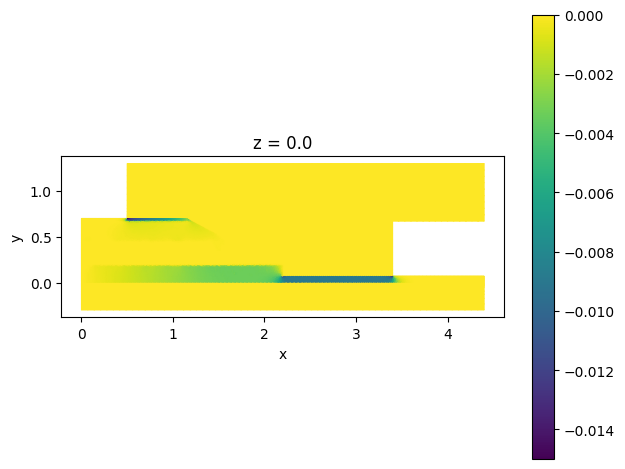

In [44]:
# Visualize the x component of the electric current density
results[j_mnt.name].J.sel(z=0, voltage=-10, method="nearest").sel(axis=0).plot(
    grid=False, vmin=-0.015, vmax=0
)
plt.show()

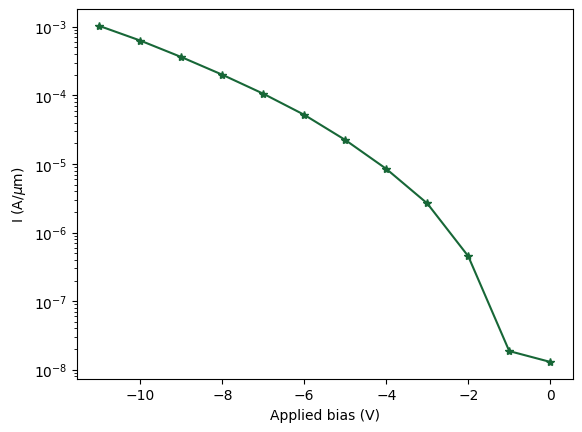

In [45]:
# Plot the dark current
I = abs(results.device_characteristics.steady_dc_current_voltage)
fig, ax = plt.subplots()
ax.plot(I.v, I, marker="*")
ax.set_ylabel(r"I (A/$\mu$m)")
ax.set_xlabel("Applied bias (V)")
ax.set_yscale("log")
plt.show()

### Photocurrent Simulation

Next, we update our semiconductor media with a [DistributedGeneration](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DistributedGeneration.html) object, using <i>from_rate_um3</i>, where we input the calculated generation rate.

In [46]:
# Apply generation rate to semiconductor materials
charge_structs = []
for struct in structures:
    if isinstance(struct.medium.charge, td.SemiconductorMedium):
        sc = struct.medium
        R = list(sc.charge.R)
        R.append(td.DistributedGeneration.from_rate_um3(gen_um3=g))
        sc = sc.updated_copy(charge=sc.charge.updated_copy(R=R))
        charge_structs.append(struct.updated_copy(medium=sc))
    else:
        charge_structs.append(struct)
scene = scene.updated_copy(structures=charge_structs)

sim_with_g = td.HeatChargeSimulation.from_scene(
    scene=scene,
    size=(si_b_w, total_h, 0),
    center=(si_b_w / 2, total_h / 2 - sio2_h / 2, 0),
    monitors=monitors,
    grid_spec=mesh_spec,
    boundary_spec=bcs,
    analysis_spec=analysis_type,
)

### Run Bright Simulation

In [47]:
results_with_g = web.run(sim_with_g, task_name="APD_charge")

18:10:20 -03 Created task 'APD_charge' with resource_id                         
             'hec-2cd44243-168e-4a60-971b-444fc76bdf8a' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

18:10:37 -03 Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:10:39 -03 status = success

Output()

18:11:08 -03 Loading simulation from simulation_data.hdf5

Finally, we plot the dark and bright currents together. 

Over the whole bias range, the bright current remains higher than the dark current, and both increase monotonically with reverse bias. Around −2 V we observe the unity-gain operating point, where the onset of impact ionization occurs, consistent with the value reported in the paper.

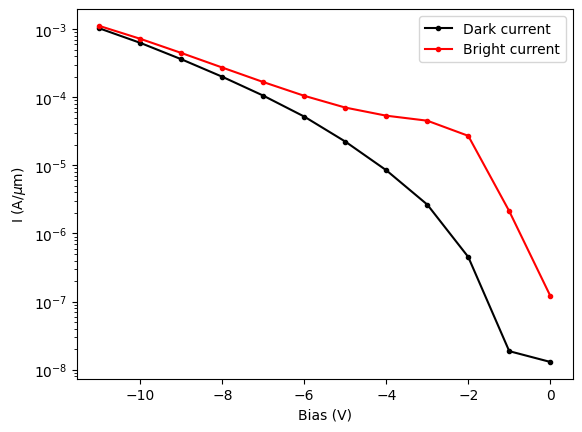

In [48]:
I_dark = abs(results.device_characteristics.steady_dc_current_voltage.data)
I = abs(results_with_g.device_characteristics.steady_dc_current_voltage.data)
V = results.device_characteristics.steady_dc_current_voltage.coords["v"]

plt.semilogy(V, I_dark, "k.-", label="Dark current")
plt.semilogy(V, I, "r.-", label="Bright current")
plt.legend()
plt.xlabel("Bias (V)")
plt.ylabel(r"I (A/$\mu$m)")  # Label for y-axis
plt.show()